<a href="https://colab.research.google.com/github/Uemerson/bidirectional-lstm-bitcoin-prices/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import necessary libs

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Bidirectional, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import time
from sklearn.metrics import mean_squared_error

# Connect with google drive

In [2]:
# mount drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Load dataset

In [3]:
# Local dataset
# dataset = pd.read_csv('coin_Bitcoin.csv')

# Using github
dataset = pd.read_csv('https://raw.githubusercontent.com/Uemerson/bidirectional-lstms-bitcoin-prices/main/coin_Bitcoin.csv')

dataset.shape

(2991, 10)

In [4]:
dataset.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


#Prepare data

In [5]:
# Remove all NaN-containing entries
df = dataset.dropna()

In [6]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 257.0+ KB


In [8]:
df.shape

(2991, 10)

#Create training and validation datasets

Now let us define the function called create_dataset, which take three inputs:

1. X - numpy array that we want to convert into a X dataset
2. y - numpy array that we want to convert into a y dataset
3. time_steps - number of previous time steps to use as input variables to predict the next time period

In [9]:
def create_dataset(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X[i:(i + time_steps)]
    Xs.append(v)
    ys.append(y[i + time_steps])

  return np.array(Xs), np.array(ys)

In [10]:
# select open, high, low and volumn columns
X = df[['Open', 'High', 'Low', 'Volume']]
# select close columns
y = df[['Close']]

# normalization (ReLU)
# X_transformer = MinMaxScaler((0,1))
# y_transformer = MinMaxScaler((0,1))

# normalization (Tanh)
X_transformer = MinMaxScaler((-1,1))
X_transformer = X_transformer.fit(X)

y_transformer = MinMaxScaler((-1,1))
y_transformer = y_transformer.fit(y)

training_size=int(len(df)*0.9)
test_size=int(len(df)-training_size)

X_train, X_test, y_train, y_test = X[0:training_size], X[training_size:training_size+test_size], y[0:training_size], y[training_size:training_size+test_size]

# transform datasets
X_train_transform = X_transformer.transform(X_train)
X_test_transform = X_transformer.transform(X_test)

y_train_transform = y_transformer.transform(y_train)
y_test_transform = y_transformer.transform(y_test)

In [11]:
# 15 days
time_steps = 15

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(X_train_transform, y_train_transform, time_steps)
X_test, y_test = create_dataset(X_test_transform, y_test_transform, time_steps)

In [12]:
X_train.shape

(2676, 15, 4)

In [13]:
X_test.shape

(285, 15, 4)

#Enabling and testing the GPU

In [14]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#LSTM Model

In [15]:
# define model
model = Sequential()

hidden_neurons_layer = 64
# hidden_neurons_layer = (int(X_train.shape[2]*2/3))+1

neurons_output = 1
dropout=0.2

# 1
model.add(LSTM(units=hidden_neurons_layer, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='tanh'))
model.add(Dropout(rate=dropout))

# 2
model.add(LSTM(units=hidden_neurons_layer*2, return_sequences=True, activation='tanh'))
model.add(Dropout(rate=dropout))

# 3
model.add(LSTM(units=hidden_neurons_layer, return_sequences=False, activation='tanh'))
model.add(Dropout(rate=dropout))

# output Layer
model.add(Dense(units=neurons_output))
# Set activation function (If your problem is a regression problem, you should use a linear activation function)
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 15, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 15, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=1e-3)
mc = ModelCheckpoint('lstm-bitcoin-prices-best-model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

start = time.time()

with tf.device('/device:GPU:0'):
  # fit model to training data
  history = model.fit(
      X_train,
      y_train,
      epochs=1000,
      batch_size=16,
      validation_data=(X_test, y_test),
      use_multiprocessing=True,
      callbacks=[es, mc])
  print("Training completed")

# fit model to training data without GPU
# history = model.fit(
#       X_train,
#       y_train,
#       epochs=1000,
#       batch_size=16,
#       validation_data=(X_test, y_test),
#       use_multiprocessing=True,
#       callbacks=[es, mc])

print(f'training time: {time.time() - start}')

Epoch 1/1000
167/168 [============================>.] - ETA: 0s - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 1: val_loss improved from inf to 0.02494, saving model to lstm-bitcoin-prices-best-model.h5
168/168 [==============================] - 14s 26ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 2/1000
168/168 [==============================] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 2: val_loss improved from 0.02494 to 0.02411, saving model to lstm-bitcoin-prices-best-model.h5
168/168 [==============================] - 3s 18ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 3/1000
167/168 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 3: val_loss improved from 0.02411 to 0.02268, saving model to lstm-bitcoin-prices-best-model.h5
168/168 [==============================] - 3s 18ms/step - loss: 0.006

##Save trained model

In [18]:
# save trained model
model.save("lstm-bitcoin-prices-model.h5")
print("lstm-bitcoin-prices-model.h5 saved model to disk in ", os.getcwd())

# save on google drive
model.save("/content/gdrive/My Drive/Colab Notebooks/forecasting/lstm-bitcoin-prices-model.h5")

# save best model on google drive
!cp "lstm-bitcoin-prices-best-model.h5" "/content/gdrive/My Drive/Colab Notebooks/forecasting/lstm-bitcoin-prices-best-model.h5"

lstm-bitcoin-prices-model.h5 saved model to disk in  /content


## Plot results LSTM

1. Training and validation loss

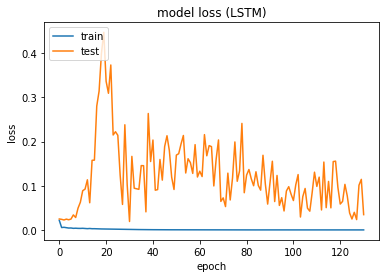

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (LSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2. Evaluate model with train dataset

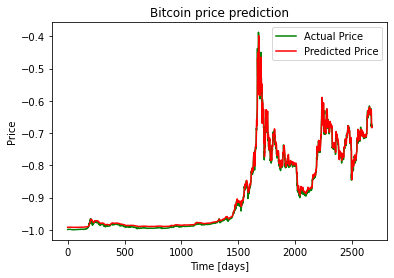

In [20]:
y_hat_train = model.predict(X_train)
 
plt.plot(y_train, label="Actual Price", color='green')
plt.plot(y_hat_train, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

3. Evaluate model with test dataset

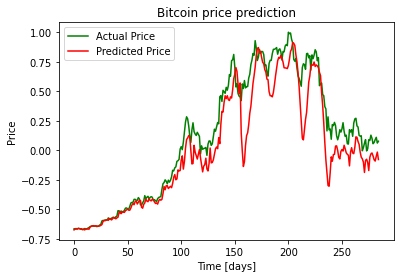

In [21]:
y_hat = model.predict(X_test)
 
plt.plot(y_test, label="Actual Price", color='green')
plt.plot(y_hat, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

## RMSE of test dataset

In [22]:
rmse_train = mean_squared_error(y_train, y_hat_train, squared=False)
rmse_test = mean_squared_error(y_test, y_hat, squared=False)

print(f'RMSE train: {rmse_train}')
print(f'RMSE test: {rmse_test}')

RMSE train: 0.009931528656348863
RMSE test: 0.18645568407159813


#Bidirectional LSTM Model

In [23]:
# define model
model = Sequential()

hidden_neurons_layer = 64
# hidden_neurons_layer = (int(X_train.shape[2]*2/3))+1

neurons_output = 1
dropout=0.2

# 1
model.add(Bidirectional(LSTM(units=hidden_neurons_layer, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=dropout))

# 2
model.add(Bidirectional(LSTM(units=hidden_neurons_layer*2, return_sequences=True, activation='tanh')))
model.add(Dropout(rate=dropout))

# 3
model.add(Bidirectional(LSTM(units=hidden_neurons_layer, return_sequences=False, activation='tanh')))
model.add(Dropout(rate=dropout))

# output Layer
model.add(Dense(units=neurons_output))
# Set activation function (If your problem is a regression problem, you should use a linear activation function)
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 15, 128)          35328     
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 15, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 256)          263168    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 15, 256)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                      

In [25]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, min_delta=1e-3)
mc = ModelCheckpoint('bidirectional-lstm-bitcoin-prices-best-model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

start = time.time()

with tf.device('/device:GPU:0'):
  # fit model to training data
  history = model.fit(
      X_train,
      y_train,
      epochs=1000,
      batch_size=16,
      validation_data=(X_test, y_test),
      use_multiprocessing=True,
      callbacks=[es, mc])
  print("Training completed")

# fit model to training data without GPU
# history = model.fit(
#       X_train,
#       y_train,
#       epochs=1000,
#       batch_size=16,
#       validation_data=(X_test, y_test),
#       use_multiprocessing=True,
#       callbacks=[es, mc])

print(f'training time: {time.time() - start}')

Epoch 1/1000
167/168 [============================>.] - ETA: 0s - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 1: val_loss improved from inf to 0.02207, saving model to bidirectional-lstm-bitcoin-prices-best-model.h5
168/168 [==============================] - 19s 49ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 2/1000
167/168 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 2: val_loss did not improve from 0.02207
168/168 [==============================] - 6s 33ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 3/1000
167/168 [============================>.] - ETA: 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 3: val_loss improved from 0.02207 to 0.01788, saving model to bidirectional-lstm-bitcoin-prices-best-model.h5
168/168 [==============================] - 6s 34ms/step - loss: 0.0032 - mean_squared_error: 0.0

##Save trained model

In [26]:
# save trained model
model.save("bidirectional-lstm-bitcoin-prices-model.h5")
print("bidirectional-lstm-bitcoin-prices-model.h5 saved model to disk in ", os.getcwd())

# save on google drive
model.save("/content/gdrive/My Drive/Colab Notebooks/forecasting/bidirectional-lstm-bitcoin-prices-model.h5")

# save best model on google drive
!cp "lstm-bitcoin-prices-best-model.h5" "/content/gdrive/My Drive/Colab Notebooks/forecasting/bidirectional-lstm-bitcoin-prices-best-model.h5"

bidirectional-lstm-bitcoin-prices-model.h5 saved model to disk in  /content


## Plot results LSTM

1. Training and validation loss

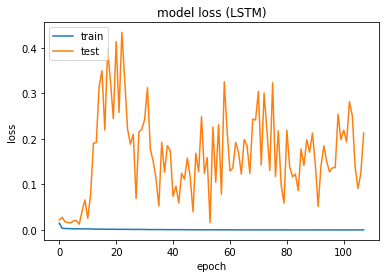

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (LSTM)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2. Evaluate model with train dataset

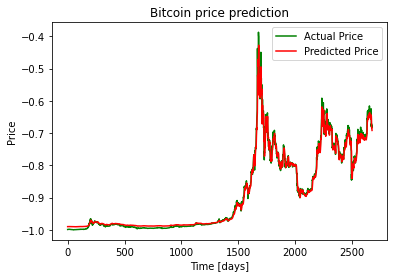

In [28]:
y_hat_train = model.predict(X_train)
 
plt.plot(y_train, label="Actual Price", color='green')
plt.plot(y_hat_train, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

3. Evaluate model with test dataset

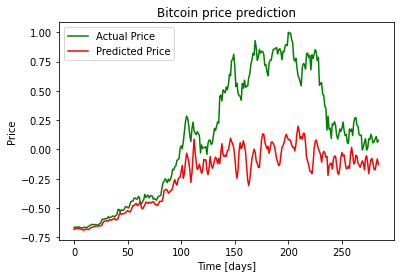

In [29]:
y_hat = model.predict(X_test)
 
plt.plot(y_test, label="Actual Price", color='green')
plt.plot(y_hat, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

## RMSE of test dataset

In [30]:
rmse_train = mean_squared_error(y_train, y_hat_train, squared=False)
rmse_test = mean_squared_error(y_test, y_hat, squared=False)

print(f'RMSE train: {rmse_train}')
print(f'RMSE test: {rmse_test}')

RMSE train: 0.01094297786774514
RMSE test: 0.46144258583132297
